# Tutorial 4: Use SEDR to process Stereo-seq data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix

In [2]:
import SEDR

random_seed = 2023
SEDR.fix_seed(random_seed)

### Loading data

In [3]:
data_root = Path('../data/Stereo-seq')

In [4]:
if not os.path.exists(data_root / 'raw.h5ad'):
    counts = pd.read_csv(data_root / 'RNA_counts.tsv.gz', sep='\t', index_col=0).T
    counts.index = [f'Spot_{i}' for i in counts.index]
    adata = sc.AnnData(counts)
    adata.X = csr_matrix(adata.X, dtype=np.float32)

    df_pos = pd.read_csv(data_root / 'position.tsv', sep='\t')
    adata.obsm['spatial'] = df_pos[['y','x']].values
    
    used_barcode = pd.read_csv(os.path.join(data_root / 'used_barcodes.txt'), sep='\t', header=None)
    used_barcode = used_barcode[0]
    adata = adata[used_barcode,]
    
    adata.write( data_root / 'raw.h5ad')
else:
    adata = sc.read_h5ad( data_root / 'raw.h5ad')

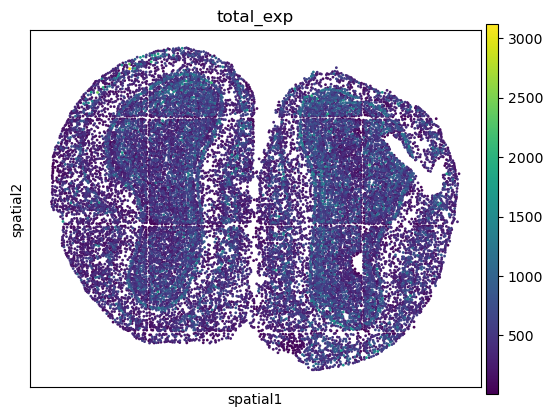

In [5]:
adata.obs['total_exp'] = adata.X.sum(axis=1)
fig, ax = plt.subplots()
sc.pl.spatial(adata, color='total_exp', spot_size=40, show=False, ax=ax)
ax.invert_yaxis()

### Preprocessing

In [6]:
adata.layers['count'] = adata.X.toarray()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.scale(adata)

from sklearn.decomposition import PCA
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

# construct graph
graph_dict = SEDR.graph_construction(adata, 6)

### Running SEDR

In [7]:
sedr_net = SEDR.Sedr(adata.obsm['X_pca'], graph_dict)
using_dec = True
if using_dec:
    sedr_net.train_with_dec()
else:
    sedr_net.train_without_dec()
sedr_feat, _, _, _ = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat

100%|██████████| 200/200 [00:03<00:00, 50.12it/s]


### Clustering

In [8]:
n_clusters = 10
SEDR.mclust_R(adata, n_clusters, use_rep='SEDR', key_added='SEDR')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'total_exp', 'SEDR'
    var: 'mean', 'std'
    obsm: 'spatial', 'X_pca', 'SEDR'
    layers: 'count'

### Visualization

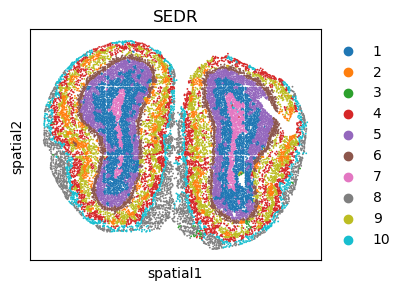

In [9]:
fig, ax = plt.subplots(1,1,figsize=(4*1,3))
sc.pl.spatial(adata, color='SEDR', spot_size=40, show=False, ax=ax)
ax.invert_yaxis()

#### Each cluster

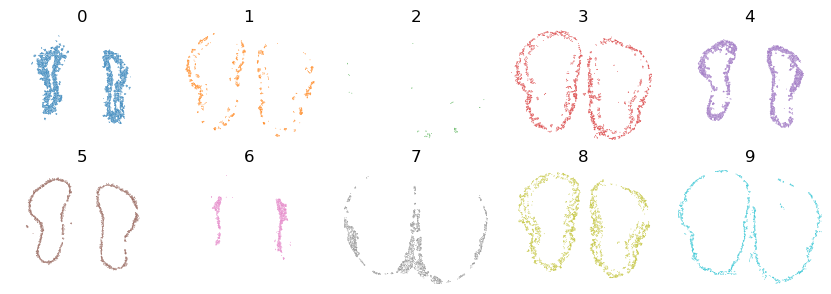

In [10]:
fig, axes = plt.subplots(2,5,figsize=(1.7*5, 1.5*2), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(n_clusters):
    sub = adata[adata.obs['SEDR'] == i+1]
    sc.pl.spatial(sub, spot_size=30, color='SEDR', ax=axes[i], legend_loc=None, show=False)
    axes[i].set_title(i)
    
    
xmin = adata.obsm['spatial'][:, 0].min()
xmax = adata.obsm['spatial'][:, 0].max()
ymin = adata.obsm['spatial'][:, 1].min()
ymax = adata.obsm['spatial'][:, 1].max()

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()
